# Ion Temperature Gradient Drift Dispersion (Kappa Distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plasmapy
from scipy import special as sp
import scipy.optimize as op
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
mi2me = 1836
ve2vi = 150
L_t2rho_i = 10
wp_i2wc_i = 100
ky_rho_i = 0.1

kappa_e = 1.8
kappa_i = 1.8
fke = np.sqrt(kappa_e/(kappa_e-0.5))
fki = np.sqrt(kappa_i/(kappa_i-0.5))

print('Te/Ti')
print('MM',ve2vi**2/mi2me)
print('MK',ve2vi**2/mi2me*(kappa_i-3/2)/kappa_i)
print('KM',ve2vi**2/mi2me/(kappa_e-3/2)*kappa_e)
print('KK',ve2vi**2/mi2me*(kappa_i-3/2)/(kappa_e-3/2)*kappa_e/kappa_i)

Te/Ti
MM 12.254901960784315
MK 2.0424836601307192
KM 73.52941176470588
KK 12.254901960784315


### define four models
- M for Maxwellian electrons and ions
- MK for Maxwellian electrons and kappa ions
- KM for kappa electrons and Maxwellian ions
- K for kappa electrons and ions
- MK_diff_Lt for Maxwellian electrons and kappa ions for different $L_T/\rho_i$

In [8]:
terms = 300 # number of terms for the integration
gl_1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
gl_2 = sp.roots_genlaguerre(terms,kappa_i-1.5)
gl_e = sp.roots_genlaguerre(terms,kappa_e-0.5)

def PDRM(w2wc,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = ky2kz/L_t2rho_i/np.sqrt(2)
    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)
    
    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0
    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2
    return [r.real,r.imag]

def PDRMK(w2wc,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)

    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    ri1 =  np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 =  np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRKM(w2wc,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i

    g0 = sp.ive(0,ky_rho_i**2)
    g1 = sp.ive(1,ky_rho_i**2)

    Ke_integrad = lambda be: np.sqrt(be) * zeta_e * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)
    re = 1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)

    ri1 = (zeta_i-zeta_ni+0.5*zeta_ti)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*g0
    ri2 = zeta_ti*(0.5*zeta_i*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i)*g0-plasmapy.dispersion.plasma_dispersion_func(zeta_i)*ky_rho_i**2*(g1-g0))
    ri = 1.0 + ri1 + ri2

    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRK(w2wc,kz_rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki*fke
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    Ke_integrad = lambda be: np.sqrt(be) * zeta_e * plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*sp.ive(0,ky_rho_e**2/be)
    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)
    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    re =  1.0 + np.dot(gl_e[1],Ke_integrad(gl_e[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    ri1 = np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 = np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

def PDRMK_diff_Lt(w2wc,kz_rho_i,L_t2rho_i):
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)

    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    ri1 =  np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 =  np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

### (a) different kappa indices

In [43]:
ks_pow = -5
ke_pow = -1.8
ks = 10**ks_pow
ke = 10**ke_pow
w_theo = 0.5*(1.0/L_t2rho_i*ky_rho_i*ks**2*ve2vi**2/mi2me)**(1/3)
r_theo = 0.5*np.sqrt(3)*(1.0/L_t2rho_i*ky_rho_i*ks**2*ve2vi**2/mi2me)**(1/3)
print('theo for M')
print(w_theo,r_theo)

wguess_m = w_theo*0.5
rguess_m = r_theo*0.1
wguess_k = 1e-4
rguess_k = -1e-7

mth = 'hybr' # root finding method
sM=op.root(lambda w:PDRM(w,ks),[wguess_m,rguess_m],method=mth)
sMK=op.root(lambda w:PDRMK(w,ks),[wguess_k,rguess_k],method=mth)
sKM=op.root(lambda w:PDRKM(w,ks),[wguess_k,rguess_k],method=mth)
sK=op.root(lambda w:PDRK(w,ks),[wguess_k,rguess_k],method=mth)
print('M',sM.success)
print(sM.x[0],sM.x[1])
print('MK',sMK.success)
print(sMK.x[0],sMK.x[1])
print('KM',sKM.success)
print(sKM.x[0],sKM.x[1])
print('K',sK.success)
print(sK.x[0],sK.x[1])

theo for M
0.00011527627952187576 0.00019966437303940054
M True
0.00010743054487245054 4.7140287715640787e-07
MK True
0.0001106826295119308 -2.848068301768685e-05
KM True
0.00010602464923543855 3.347656568593195e-07
K True
0.00011024715081351939 -2.8430474387720177e-05


In [44]:
pow_idx = np.linspace(ks_pow,ke_pow,num=400)
kz_rho_i_list = 10**pow_idx

w_M_list = []
r_M_list = []
w_MK_list = []
r_MK_list = []
w_KM_list = []
r_KM_list = []

wgm =wguess_m
rgm =rguess_m
wgmk =wguess_k
rgmk =rguess_k
wgkm =wguess_k
rgkm =rguess_k

for ki in tqdm(kz_rho_i_list):
    sM=op.root(lambda w:PDRM(w,ki),[wgm,rgm],method=mth)
    w_M_list.append(sM.x[0])
    r_M_list.append(sM.x[1])
    wgm = sM.x[0]*0.7
    rgm = sM.x[1]*0.6
    
    sMK=op.root(lambda w:PDRMK(w,ki),[wgmk,rgmk],method=mth)
    w_MK_list.append(sMK.x[0])
    r_MK_list.append(sMK.x[1])
    wgmk = sMK.x[0]*0.7
    rgmk = sMK.x[1]*0.6

    sKM=op.root(lambda w:PDRKM(w,ki),[wgkm,rgkm],method=mth)
    w_KM_list.append(sKM.x[0])
    r_KM_list.append(sKM.x[1])
    wgkm = round(sKM.x[0],6)
    rgkm = round(sKM.x[1],6)

100%|██████████| 400/400 [00:01<00:00, 208.65it/s]


In [45]:
wguess_1 = 1e-4
rguess_1 = -1e-7
wguess_2 = 1e-4
rguess_2 = -1e-7
wguess_3 = 1e-4
rguess_3 = -1e-7

L_t2rho_i_1 = 10
L_t2rho_i_2 = 15
L_t2rho_i_3 = 20

mth = 'hybr' # root finding method
s1=op.root(lambda w:PDRMK_diff_Lt(w,ks,L_t2rho_i_1),[wguess_1,rguess_1],method=mth)
s2=op.root(lambda w:PDRMK_diff_Lt(w,ks,L_t2rho_i_2),[wguess_2,rguess_2],method=mth)
s3=op.root(lambda w:PDRMK_diff_Lt(w,ks,L_t2rho_i_3),[wguess_3,rguess_3],method=mth)
print('1',s1.success)
print(s1.x[0],s1.x[1])
print('2',s2.success)
print(s2.x[0],s2.x[1])
print('3',s3.success)
print(s3.x[0],s3.x[1])

1 True
0.0001106826295119308 -2.848068301768685e-05
2 True
0.0001115105416594859 -2.860210869345548e-05
3 True
0.00011237321032598871 -2.8728861258916032e-05


In [46]:
w_1_list = []
r_1_list = []
w_2_list = []
r_2_list = []
w_3_list = []
r_3_list = []

wg1=wguess_1
rg1=rguess_1
wg2=wguess_2
rg2=rguess_2
wg3=wguess_3
rg3=rguess_3

for ki in tqdm(kz_rho_i_list):
    s1=op.root(lambda w:PDRMK_diff_Lt(w,ki,L_t2rho_i_1),[wg1,rg1],method=mth)
    w_1_list.append(s1.x[0])
    r_1_list.append(s1.x[1])
    wg1 = s1.x[0]*0.7
    rg1 = s1.x[1]*0.6
    
    s2=op.root(lambda w:PDRMK_diff_Lt(w,ki,L_t2rho_i_2),[wg2,rg2],method=mth)
    w_2_list.append(s2.x[0])
    r_2_list.append(s2.x[1])
    wg2 = s2.x[0]*0.7
    rg2 = s2.x[1]*0.6

    s3=op.root(lambda w:PDRMK_diff_Lt(w,ki,L_t2rho_i_3),[wg3,rg3],method=mth)
    w_3_list.append(s3.x[0])
    r_3_list.append(s3.x[1])
    wg3 = s3.x[0]*0.7
    rg3 = s3.x[1]*0.6

100%|██████████| 400/400 [00:03<00:00, 102.16it/s]


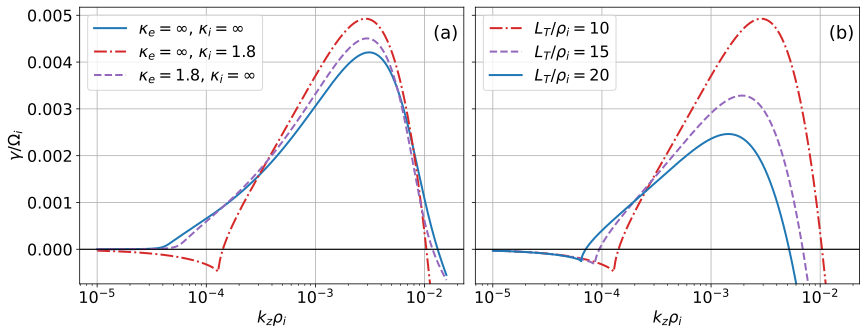

In [56]:
xticks = 10**np.linspace(ks_pow,int(ke_pow-1),num=int(ke_pow-1)-ks_pow+1)
ylim = np.max([r_M_list,r_MK_list,r_KM_list])
yticks = [0.000,0.001,0.002,0.003,0.004,0.005]

fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(kz_rho_i_list,r_M_list, label=r'$\kappa_e=\infty$, $\kappa_i=\infty$',color='tab:blue', linestyle='-')
ax1.plot(kz_rho_i_list,r_MK_list, label=r'$\kappa_e=\infty$, $\kappa_i=$'+str(kappa_i), color='tab:red', linestyle='-.')
ax1.plot(kz_rho_i_list,r_KM_list, label=r'$\kappa_e=$'+str(kappa_e)+r', $\kappa_i=\infty$', color='tab:purple', linestyle='--')
ax1.text(1.2e-2,0.0045,r'(a)',fontsize=18)
ax1.axhline(0,color='black',linewidth=1.1)
ax1.set_xlabel(r'$k_z\rho_i$')
ax1.set_ylabel(r'$\gamma/\Omega_i$')
ax1.set_xscale('log')
ax1.set_ylim(-0.15*ylim,ylim*1.05)
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.grid()
ax1.legend(loc=2)

ax2.plot(kz_rho_i_list,r_1_list, label=r'$L_T/\rho_i=$'+str(L_t2rho_i_1), color='tab:red', linestyle='-.')
ax2.plot(kz_rho_i_list,r_2_list, label=r'$L_T/\rho_i=$'+str(L_t2rho_i_2), color='tab:purple', linestyle='--')
ax2.plot(kz_rho_i_list,r_3_list, label=r'$L_T/\rho_i=$'+str(L_t2rho_i_3), color='tab:blue', linestyle='-')
ax2.text(1.2e-2,0.0045,r'(b)',fontsize=18)
ax2.axhline(0,color='black',linewidth=1.1)
ax2.set_xlabel(r'$k_z\rho_i$')
ax2.set_xscale('log')
ax2.set_ylim(-0.15*ylim,ylim*1.05)
ax2.set_xticks(xticks)
ax2.set_yticks(yticks,[])
ax2.grid()
ax2.legend(loc=2)

fig.subplots_adjust(wspace=0.03)
# plt.savefig('./fig3_dispersion_vs_kzrhoi_smallkappa.pdf', bbox_inches='tight')
plt.show()